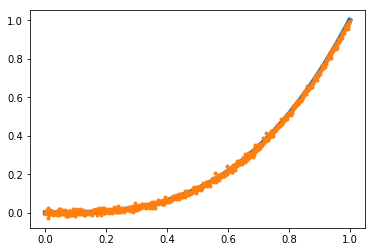

In [22]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib

import numpy as np
#np.random.seed(99)
f = lambda x: 1*x**3 
xgrid = np.linspace(0.,1., 640)
fgrid = f(xgrid)
ygrid = fgrid + 0.01*np.random.normal(size=640)

%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(xgrid, fgrid, lw=5)
plt.plot(xgrid, ygrid, '.')


xdata = Variable(torch.Tensor(xgrid))
ydata = Variable(torch.Tensor(ygrid))



In [23]:
class MLRegP(nn.Module):
    def __init__(self, input_dim, hidden_dim, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(MLRegP, self).__init__()
        self.fc_initial = nn.Linear(input_dim, hidden_dim)
        self.fc_mid = nn.ModuleList()
        self.additional_hidden_wide = additional_hidden_wide
        for i in range(self.additional_hidden_wide):
            self.fc_mid.append(nn.Linear(hidden_dim, hidden_dim))
        self.fc_final = nn.Linear(hidden_dim, 1)
        self.nonlinearity = nonlinearity

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.nonlinearity(x)
        for i in range(self.additional_hidden_wide):
            x = self.fc_mid[i](x)
            x = self.nonlinearity(x)
        x = self.fc_final(x)
        return x

In [24]:
model = MLRegP(1, 40, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.MSELoss()
print(model)


MLRegP(
  (fc_initial): Linear(in_features=1, out_features=40, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=40, out_features=40, bias=True)
  )
  (fc_final): Linear(in_features=40, out_features=1, bias=True)
)


In [25]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(torch.from_numpy(xgrid.reshape(-1,1)), torch.from_numpy(ygrid))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


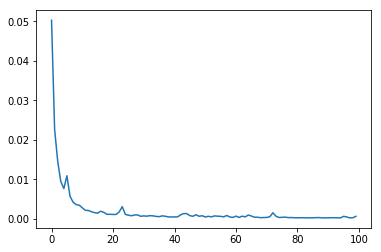

In [26]:
lr, epochs, batch_size = 1e-1 , 100 , 64
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for localx, localy in iter(loader):
        localx = Variable(localx.float())
        localy = Variable(localy.float())
        output = model.forward(localx)
        loss = criterion(output, localy)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      


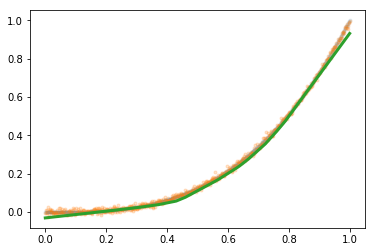

In [27]:
finaloutput = model.forward(xdata.view(-1,1))
plt.plot(xgrid, fgrid, '.', alpha=0.1)
plt.plot(xgrid, ygrid, '.', alpha=0.2)
plt.plot(xgrid, finaloutput.data.numpy(), lw=3)